<a href="https://colab.research.google.com/github/jooj-uni/neural-signal-analysis-bci/blob/master/moabb_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne
!pip install moabb
!pip install autoreject

# Imports

In [ ]:
import warnings

import matplotlib.pyplot as plt
import mne
import seaborn as sns
from mne.decoding import CSP
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

import moabb
from moabb.datasets import BNCI2014_001, Zhou2016
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

import numpy as np
import pandas as pd
import seaborn as sns

from autoreject import compute_thresholds, get_rejection_threshold

import os


# Config para conseguir usar os datasets no colab

In [ ]:
# Caminho seguro no Colab
mne_path = "/content/mne_data"
os.environ["MNE_DATA"] = mne_path
os.environ["MNE_DATASETS_SAMPLE_PATH"] = mne_path
os.environ["MOABB_RESULTS"] = mne_path # Set MOABB results directory using os.environ
os.makedirs(mne_path, exist_ok=True)

# Forçar MNE a registrar o caminho internamente
mne.set_config("MNE_DATA", mne_path, set_env=True)
mne.set_config("MNE_DATASETS_SAMPLE_PATH", mne_path, set_env=True)

Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)


# Transformador de rejeição por limiar

Deve ser usado como primeiro passo num pipeline (make_pipeline, não make_process_pipeline).

essa classe precisa de muita RAM e mais poder computacional, mas é mais robusta.

In [ ]:
class ThresholdReject (BaseEstimator, TransformerMixin):
  """
  Calcula limiares de rejeição pelo autoreject em um subset de dados de treino
  para cada split, evitando vazamento de dados.
  """
  def __init__(self, random_state=42, subset_size=30, decim=4):
    self.random_state = random_state
    self.subset_size = subset_size
    self.decim = decim
    self.thresholds_ = None

  def fit(self, X, y=None):
    if not isinstance(X, mne.BaseEpochs):
      raise TypeError(f"X deve ser um objeto mne.Epochs, mas é {type(X)}")

    #garante um tamanho suficiente para o cálculo
    n_trials = min(len(X), self.subset_size)

    if n_trials < 10:
      self.thresholds_ = {}
      return self

    #usa um subset aleatório dos dados
    rng = np.random.default_rng(self.random_state)
    idx = rng.choice(len(X), size=n_trials, replace=False)
    subset = X[idx]

    self.thresholds_ = compute_thresholds(
        subset,
        method='random_search',
        random_state=self.random_state,
        verbose=False
    )

    return self

  def transform(self, X, y=None):
    if not isinstance(X, mne.BaseEpochs):
      raise TypeError(f"X deve ser um objeto mne.Epochs, mas é {type(X)}")

    data = X.get_data()
    bad_epochs = []

    #aplica a rejeição de trials baseado nos limiares de cada canal
    for i, trial in enumerate(data):
      for ch_idx, ch_name in enumerate(X.info["ch_names"]):
        if np.max(np.abs(trial[ch_idx])) > self.thresholds_[ch_name]:
          bad_epochs.append(i)
          break
    X.drop(bad_epochs)
    return X

versão que calcula um limiar global, ao invés de um para cada canal

In [ ]:
class ThresholdReject (BaseEstimator, TransformerMixin):
  """
  Calcula limiares de rejeição pelo autoreject em um subset de dados de treino
  para cada split, evitando vazamento de dados.
  """
  def __init__(self, random_state=42, subset_size=30, decim=4):
    self.random_state = random_state
    self.subset_size = subset_size
    self.decim = decim
    self.thresholds_ = None

  def fit(self, X, y=None):
    if not isinstance(X, mne.BaseEpochs):
      raise TypeError(f"X deve ser um objeto mne.Epochs, mas é {type(X)}")

    #garante um tamanho suficiente para o cálculo
    n_trials = min(len(X), self.subset_size)

    if n_trials < 10:
      self.thresholds_ = {}
      return self

    #usa um subset aleatório dos dados
    rng = np.random.default_rng(self.random_state)
    idx = rng.choice(len(X), size=n_trials, replace=False)
    subset = X[idx]

    self.thresholds_ = get_rejection_threshold(
        subset,
        decim=self.decim,
        random_state=self.random_state,
        verbose=False
    )

    return self

  def transform(self, X, y=None):
    if not isinstance(X, mne.BaseEpochs):
      raise TypeError(f"X deve ser um objeto mne.Epochs, mas é {type(X)}")

    if self.thresholds_:
      data = X.get_data()

      ptp_values = np.max(data, axis=2) - np.min(data, axis=2)
      bad_epochs = []
      ch_types = X.get_channel_types()

      for i in range(ptp_values.shape[0]): # Loop sobre as épocas
            is_bad = False
            for ch_idx, ch_type in enumerate(ch_types): # Loop sobre os canais

                # Verifica se existe um limiar para este tipo de canal (ex: 'eeg')
                if ch_type in reject_dict:
                    threshold = reject_dict[ch_type]

                    if ptp_values[i, ch_idx] > threshold:
                        bad_epochs_indices.append(i)
                        is_bad = True
                        break # Vai para a próxima época
            if is_bad:
                continue

    return X.drop(bad_epochs, reason='artefato_rej', verbose=False)

#Classe para transformar o Epochs em ndarray

Essa classe é um dos exemplos da documentação do MOABB, disponível em: https://moabb.neurotechx.com/docs/auto_examples/advanced_examples/plot_mne_and_scikit_estimators.html

Isso é necessário para trabalhar nos pipelines com um objeto Epochs (que a nossa classe que implementa autoreject precisa).

In [ ]:
class MyVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        arr = X.get_data()
        self.features_shape_ = arr.shape[1:]
        return self

    def transform(self, X, y=None):
        arr = X.get_data()
        return arr.reshape(len(arr), -1)

# Definição de pipelines

In [ ]:
pipelines = {}
pipelines["csp+lda"] = make_pipeline(CSP(n_components=4), LDA())
pipelines["tgsp+svc"] = make_pipeline(Covariances(), TangentSpace(), SVC(kernel="linear"))
pipelines["mdm"] = make_pipeline(Covariances(), MDM())


# Definição de datasets e paradigma

In [ ]:
"""
class reReference(BaseEstimator, TransformerMixin):
  def __init__(datasets, paradigm, ref):
    self.datasets = datasets
    self.paradigm = paradigm
    self.ref = ref

  def rereference(raw, ref):
    if (self.ref == 'average'):
      raw.set_eeg_reference(ref_channels='average', projection=True)
      return raw

  #no nosso caso o X vai ser o Raw, eu imagino (inserindo no step de raw do make_process_pipeline, é claro)
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X = self.rereference(X, self.ref)
    return X
    """

"\nclass reReference(BaseEstimator, TransformerMixin):\n  def __init__(datasets, paradigm, ref):\n    self.datasets = datasets\n    self.paradigm = paradigm\n    self.ref = ref\n\n  def rereference(raw, ref):\n    if (self.ref == 'average'):\n      raw.set_eeg_reference(ref_channels='average', projection=True)\n      return raw\n\n  #no nosso caso o X vai ser o Raw, eu imagino (inserindo no step de raw do make_process_pipeline, é claro)\n  def fit(self, X, y=None):\n    return self\n\n  def transform(self, X, y=None):\n    X = self.rereference(X, self.ref)\n    return X\n    "

In [ ]:
def small_laplacian(epoch):
  epoch_csd = mne.preprocessing.compute_current_source_density(epoch)

  mapping = {ch: 'eeg' for ch in epoch.ch_names}

  for ch in epoch_csd.info['ch']:
    ch['unit'] = mne.io.constants.FIFF.FIFF_UNIT_V
    ch['unit_mul'] = 0

  epoch_csd.set_channel_types(mapping)

  return epoch_csd


In [ ]:
def rereference(raw, ref):
  if (ref == 'average'):
    raw.set_eeg_reference(ref_channels='average', projection=True)
  if type(ref) == list:
    for ch in ref:
      if ch not in raw.info['ch_names']:
        raise ValueError(f"Canal {ch} não está nos dados")
        break
      else:
        raw.set_eeg_reference(ref_channels=ref, projection=True)
  return raw

datasets = [BNCI2014_001()]
subj = [1, 2, 3]
for d in datasets:
    d.subject_list = subj

paradigm = LeftRightImagery()

process_pipelines = {}

for d in datasets:
  process_pipelines[d] = paradigm.make_process_pipelines(d)[0]
  process_pipelines[d].steps.insert(2, ("rereference", FunctionTransformer(rereference)))

In [ ]:
evaluation_noCAR = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets,
    overwrite=False,
)

results_noCAR = evaluation_noCAR.process(pipelines)

""" para avaliar os pipelines com pre processamento personalizado, o fluxo é um pouco diferente

evaluation.process() chama todos os pipelines para todos os datasets considerando aquele paradigma, só que ele não tem o parametro process_pipeline, ou seja, não
dá para usar um pipeline de pre-processamento personalizado.

então, temos que chamar a função evaluate, que é interna das classes evaluate. ela retorna um generator que dá os resultados da aplicação dos pipelines, mas num único
dataset
"""
resultsCAR = {}

evaluationCAR = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets
)

#se for um dataset só, então é só chamar evaluate nele
for dataset in datasets:
  resultsCAR[dataset] = evaluationCAR.evaluate(
      dataset=dataset,
      pipelines=pipelines,
      param_grid=None,
      process_pipeline=process_pipelines[dataset]
  )
  resultsCAR[dataset] = pd.DataFrame(list(resultsCAR[dataset])) #converte generator pra lista e aí converte a lista p dataframe


BNCI2014-001-WithinSession:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/moabb/datasets/download.py:56: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(

  0%|                                              | 0.00/42.8M [00:00<?, ?B/s]
  0%|                                      | 16.4k/42.8M [00:00<04:33, 156kB/s]
  0%|                                      | 32.8k/42.8M [00:00<04:44, 150kB/s]
  0%|                                      | 96.3k/42.8M [00:00<02:06, 337kB/s]
  0%|▏                                      | 209k/42.8M [00:00<01:13, 581kB/s]
  1%|▍                             

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 33 (2.2e-16 eps * 22 dim * 6.7e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 32 (2.2e-16 eps * 22 dim * 6.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 32 (2.2e-16 eps * 22 dim * 6.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  33%|███▎      | 1/3 [00:38<01:16, 38.20s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A02T.mat' to file '/content/mne_data/MNE-bnci-data/database/data-sets/001-2014/A02T.mat'.
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(

  0%|                                              | 0.00/43.1M [00:00<?, ?B/s]
  0%|                                     | 8.19k/43.1M [00:00<09:52, 72.7kB/s]
  0%|                                      | 32.8k/43.1M [00:00<04:38, 155kB/s]
  0%|                                      | 80.9k/43.1M [00:00<02:37, 273kB/s]
  0%|▏                                      | 153k/43.1M [00:00<01:45, 408kB/s]
  1%|▎                                      | 

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 37 (2.2e-16 eps * 22 dim * 7.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 36 (2.2e-16 eps * 22 dim * 7.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 37 (2.2e-16 eps * 22 dim * 7.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  67%|██████▋   | 2/3 [01:03<00:30, 30.32s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A03T.mat' to file '/content/mne_data/MNE-bnci-data/database/data-sets/001-2014/A03T.mat'.
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(

  0%|                                              | 0.00/44.1M [00:00<?, ?B/s]
  0%|                                     | 8.19k/44.1M [00:00<09:58, 73.6kB/s]
  0%|                                      | 32.8k/44.1M [00:00<04:42, 156kB/s]
  0%|                                      | 96.3k/44.1M [00:00<02:11, 335kB/s]
  0%|▏                                      | 209k/44.1M [00:00<01:15, 585kB/s]
  1%|▍                                     | 4

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 45 (2.2e-16 eps * 22 dim * 9.3e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 46 (2.2e-16 eps * 22 dim * 9.4e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 46 (2.2e-16 eps * 22 dim * 9.4e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 33 (2.2e-16 eps * 22 dim * 6.7e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 32 (2.2e-16 eps * 22 dim * 6.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 33 (2.2e-16 eps * 22 dim * 6.7e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  33%|███▎      | 1/3 [00:14<00:28, 14.25s/it]/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 37 (2.2e-16 eps * 22 dim * 7.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 37 (2.2e-16 eps * 22 dim * 7.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 37 (2.2e-16 eps * 22 dim * 7.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  67%|██████▋   | 2/3 [00:28<00:14, 14.36s/it]/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 45 (2.2e-16 eps * 22 dim * 9.3e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 46 (2.2e-16 eps * 22 dim * 9.4e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 46 (2.2e-16 eps * 22 dim * 9.4e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession: 100%|██████████| 3/3 [00:42<00:00, 14.28s/it]


# Plot

In [ ]:
  pd.set_option('display.max_columns', None)
  pd.set_option('display.max_rows', None)

In [ ]:
dfCAR = pd.concat(resultsCAR, ignore_index=True)

resultadosCAR = dfCAR.groupby("pipeline")["score"].agg(["mean", "std"]).reset_index()
resultadosnoCAR = results_noCAR.groupby("pipeline")["score"].agg(["mean", "std"]).reset_index()

print(resultadosCAR)
print(resultadosnoCAR)

   pipeline      mean       std
0   csp+lda  0.832200  0.220665
1       mdm  0.835181  0.209640
2  tgsp+svc  0.863537  0.163215
   pipeline      mean       std
0   csp+lda  0.858243  0.186281
1       mdm  0.843515  0.209679
2  tgsp+svc  0.876429  0.146377


       score      time  samples subject session  channels  n_sessions  \
0   0.930476  0.407967    144.0       1  0train        22           2   
1   0.955170  0.262922    144.0       1   1test        22           2   
2   0.688163  0.203200    144.0       2  0train        22           2   
3   0.692381  0.245169    144.0       2   1test        22           2   
4   0.994286  0.201304    144.0       3  0train        22           2   
5   0.998095  0.202974    144.0       3   1test        22           2   
6   0.945782  1.158069    144.0       1  0train        22           2   
7   0.970476  0.483632    144.0       1   1test        22           2   
8   0.619116  0.421679    144.0       2  0train        22           2   
9   0.618980  0.442580    144.0       2   1test        22           2   
10  0.997007  0.450405    144.0       3  0train        22           2   
11  0.998095  0.447098    144.0       3   1test        22           2   
12  0.954150  0.420281    144.0       1  0train    

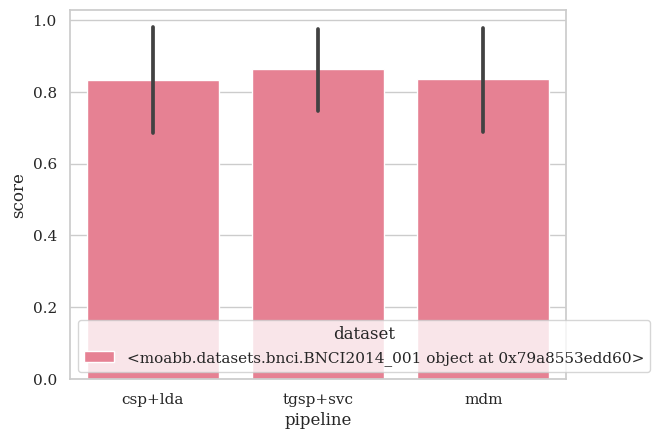

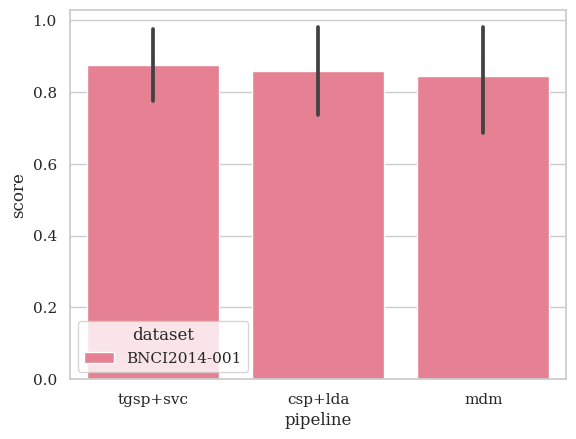

In [ ]:

print(results_noCAR)
g = sns.barplot(
    data=resultsCAR[datasets[0]],
    x="pipeline",
    y="score",
    hue="dataset"
)
plt.figure()
h = sns.barplot(
    data=results_noCAR,
    x="pipeline",
    y="score",
    hue="dataset"
)

plt.show()

# Também com seleção de canais

BNCI2014-001-WithinSession:   0%|          | 0/3 [00:00<?, ?it/s]

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None


/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/l

    Using tolerance 3.7 (2.2e-16 eps * 5 dim * 3.4e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7 (2.2e-16 eps * 5 dim * 3.3e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7 (2.2e-16 eps * 5 dim * 3.3e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Compu

BNCI2014-001-WithinSession:  33%|███▎      | 1/3 [00:09<00:18,  9.27s/it]

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None


/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/l

    Using tolerance 4.2 (2.2e-16 eps * 5 dim * 3.8e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3 (2.2e-16 eps * 5 dim * 3.9e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3 (2.2e-16 eps * 5 dim * 3.8e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Compu

BNCI2014-001-WithinSession:  67%|██████▋   | 2/3 [00:17<00:08,  8.84s/it]

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 5 (2.2e-16 eps * 5 dim * 4.5e+15  max singular value)


/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/l

    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5 (2.2e-16 eps * 5 dim * 4.5e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5 (2.2e-16 eps * 5 dim * 4.5e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.1 (2.2e-16 eps * 5 dim 

BNCI2014-001-WithinSession:   0%|          | 0/3 [00:00<?, ?it/s]

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None


/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/l

    Using tolerance 3.7 (2.2e-16 eps * 5 dim * 3.3e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7 (2.2e-16 eps * 5 dim * 3.4e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7 (2.2e-16 eps * 5 dim * 3.3e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Compu

BNCI2014-001-WithinSession:  33%|███▎      | 1/3 [00:06<00:12,  6.19s/it]/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 4.2 (2.2e-16 eps * 5 dim * 3.8e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3 (2.2e-16 eps * 5 dim * 3.9e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3 (2.2e-16 eps * 5 dim * 3.8e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 c

BNCI2014-001-WithinSession:  67%|██████▋   | 2/3 [00:13<00:06,  6.83s/it]

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 5 (2.2e-16 eps * 5 dim * 4.5e+15  max singular value)


/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/lib/python3.12/dist-packages/moabb/datasets/preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~956 KiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/usr/local/l

    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5 (2.2e-16 eps * 5 dim * 4.5e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5 (2.2e-16 eps * 5 dim * 4.5e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5 (2.2e-16 eps * 5 dim * 

BNCI2014-001-WithinSession: 100%|██████████| 3/3 [00:19<00:00,  6.53s/it]


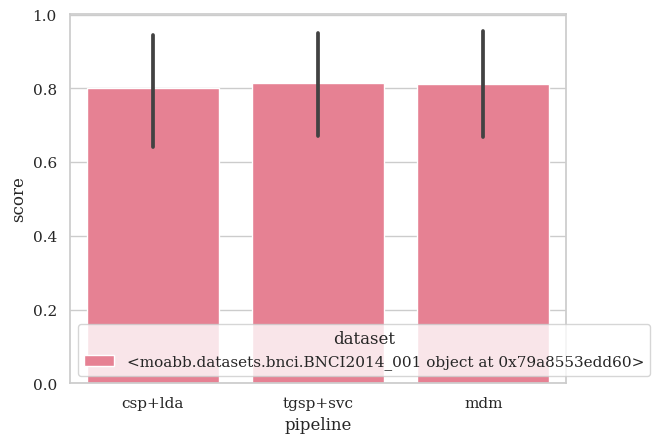

In [ ]:
paradigm = LeftRightImagery(channels=["C1", "C3", "Cz", "C2", "C4"])

evaluation_noCAR = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets,
    overwrite=False,
)

evaluationCAR = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets
)

resultsnoCAR2 = evaluation_noCAR.process(pipelines)

resultsCAR2 = evaluationCAR.evaluate(
      dataset=dataset,
      pipelines=pipelines,
      param_grid=None,
      process_pipeline=process_pipelines[dataset]
  )
resultsCAR2 = pd.DataFrame(list(resultsCAR2))

plt.figure()

g = sns.barplot(
    data=resultsCAR2,
    x="pipeline",
    y="score",
    hue="dataset"
)

In [ ]:
resultadosCAR2 = resultsCAR2.groupby("pipeline")["score"].agg(["mean", "std"]).reset_index()
resultadosnoCAR2 = resultsnoCAR2.groupby("pipeline")["score"].agg(["mean", "std"]).reset_index()

print(resultadosCAR2)
print(resultadosnoCAR2)

   pipeline      mean       std
0   csp+lda  0.801803  0.220685
1       mdm  0.812959  0.210640
2  tgsp+svc  0.814683  0.202736
   pipeline      mean       std
0   csp+lda  0.803424  0.230963
1       mdm  0.809592  0.211043
2  tgsp+svc  0.798186  0.219342
